In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import matplotlib.pyplot as plt
from dsa_analysis import simulation, simulation_line, visualize, simulation_lorenz, combine_simulations, visualize, load_config
import DSA
import seaborn as sns
import pandas as pd
from sklearn.manifold import MDS
import numpy as np
from itertools import permutations
import similarity

%load_ext autoreload
%autoreload 2

The goal in this notebook is to study the impact of combining different shapes on the DSA metric. The idea is to create a dataset with different shapes and see how the DSA metric behaves when combining them.

## Parameters

#### Lorenz attractor simulation parameters

For each configuration, we simulate with $num\_samples$ possible initializations accross $num\_steps$ 

Parameters to compute the dissimilarity matrices and the Procrustes Alignment over Vector Fields, according to [1]

In [2]:
config = load_config('../config.yaml')

## Compositionality

We here want to analyse the evolution of the dissimilarity as a function of the number of shared motifs

### Generation of the elementary motifs

We create here elementary motifs which will be repurposed as a basis for compositional motifs later

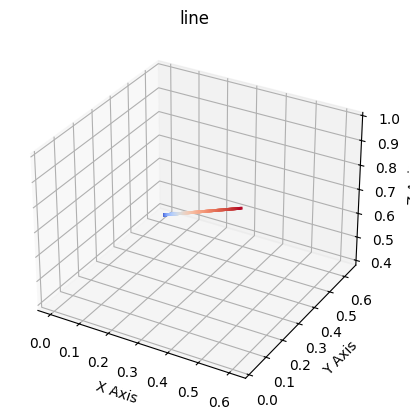

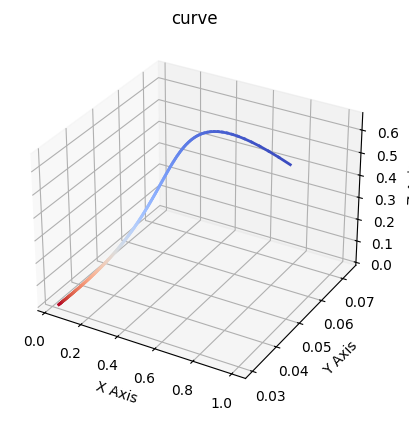

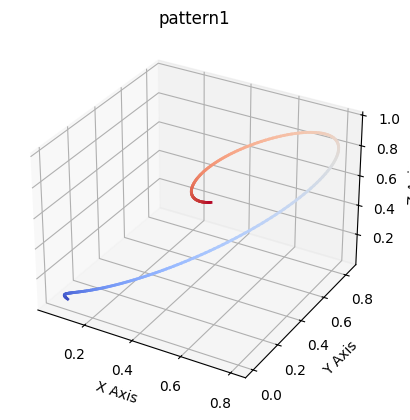

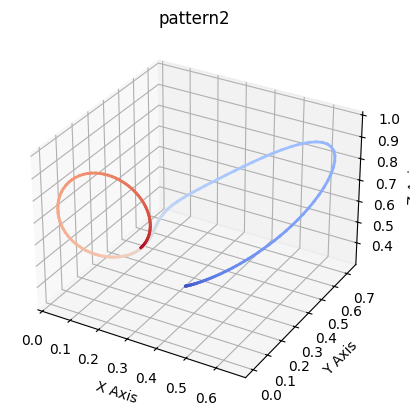

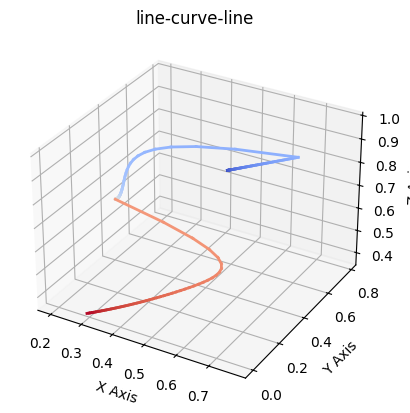

In [3]:
# Define parameters
dt = 0.01
num_steps = config['simulations']['num_steps']
num_samples = config['simulations']['num_samples']
lorenz_parameters = config['simulations']['lorenz_parameters']

# Run simulations line
simulations_line = simulation_line(num_steps, num_samples)

# Run simulations curve
simulations_curve = simulation_lorenz(dt, lorenz_parameters['one_attractor'][1], num_samples, num_steps)

# Run simulations Pattern1
simulations_pattern1 = simulation_lorenz(dt, lorenz_parameters['two_stable_attractors'][0], num_samples, num_steps)

# Run simulations Pattern2
simulations_pattern2 = simulation_lorenz(dt, lorenz_parameters['two_stable_attractors'][2], num_samples, num_steps)

# Run simulations line-curve-line-curve
combined_simulations_line_curve_line = combine_simulations([simulations_line, simulations_curve, np.flip(simulations_line, axis=0), np.flip(simulations_curve, axis=0)], method='attach')


# Visualize the simulations
visualize([simulations_line[0]],"line")
visualize([simulations_curve[0]],"curve")
visualize([simulations_pattern1[0]], "pattern1")
visualize([simulations_pattern2[0]], "pattern2")
visualize([combined_simulations_line_curve_line[0]],"line-curve-line")

### Generation of the possible compositional motifs

We here genetate all the possible permutations of $3$ different motifs among the $5$ elementary motifs. We hence have $5 \times 4 \times 3 = 60$ possible compositions.

In [4]:
combine_pattern_curve = combine_simulations([simulations_line, simulations_pattern1], method='attach')

In [5]:
motif_basis = [simulations_line, simulations_curve, simulations_pattern1,simulations_pattern2,combined_simulations_line_curve_line]
motif_names = ['Line', 'Curve', 'Pattern1', 'Pattern2','Line-Curve-Line-Curve']
motif_dict = {motif_names[i]: motif_basis[i] for i in range(len(motif_basis))}
all_simulations_length_3 = list(permutations(motif_names, 3))

In [6]:
all_simulations_combined = {permutation: combine_simulations([motif_dict[permutation[0]], motif_dict[permutation[1]], motif_dict[permutation[2]]],method='attach') for permutation in all_simulations_length_3}

One out of $60$ possible combinations

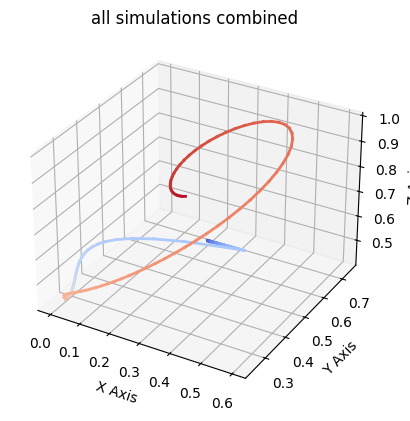

In [7]:
visualize([list(all_simulations_combined.values())[0][0]],"all simulations combined")

### DSA computation

We here measure the similarity between the 60 compositional motifs : 
- the three independant patterns, namely a line, curve and a lorenz pattern
- A combination of each 

In [8]:
model = list(all_simulations_combined.values())
model_names = list(all_simulations_combined.keys())

In [9]:
procrustes_measure = similarity.make("measure.netrep.procrustes-angular-score")
dissimilarities_pa = np.empty((len(model),len(model)))
for i in range(len(model)):
    for j in range(len(model)):
        dissimilarities_pa[i,j] = 1-procrustes_measure(model[i], model[j])

In [10]:
cka_measure = similarity.make("measure.sim_metric.cka-angular-score")
dissimilarities_cka= np.empty((len(model), len(model)))
for i in range(len(model)):
    for j in range(len(model)):
        dissimilarities_cka[i, j] = 1-cka_measure(model[i], model[j])

arccos score: 1.0 0.0 0.0
score is 1, returning 0
arccos score: 0.7977674323441639 0.64721287859649 0.20223256765583608
arccos score: 0.6514954227766243 0.8612423980124155 0.3485045772233757
arccos score: 0.7048647256982287 0.7885639030149328 0.29513527430177133
arccos score: 0.5693647797169182 0.9650633726913211 0.43063522028308177
arccos score: 0.6852826609861911 0.8158045759816231 0.31471733901380894
arccos score: 0.6635763070196129 0.8452071754131187 0.3364236929803871
arccos score: 0.5945203761736428 0.9341272970141629 0.40547962382635716
arccos score: 0.6579165341377883 0.8527474739827413 0.3420834658622117
arccos score: 0.5049651848986615 1.0414546973674932 0.4950348151013385
arccos score: 0.8341467828356665 0.5842123214174944 0.16585321716433354
arccos score: 0.684663611889786 0.8166542549262533 0.315336388110214
arccos score: 0.14584849939093925 1.4244257378853462 0.8541515006090608
arccos score: 0.032397145341223066 1.5383935115695504 0.9676028546587769
arccos score: 0.008092

In [11]:
dissimilarities_dsa = np.empty((len(model), len(model)))
dsa = DSA.DSA(
    model,
    n_delays=config["dsa"]["n_delays"],
    rank=100,
    delay_interval=config["dsa"]["delay_interval"],
    verbose=True,
    iters=1000,
    lr=1e-2,
)
dsa_scores = dsa.fit_score()
dissimilarities_dsa = dsa_scores

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HA

### Dissimilarity VS number of shared elements

We group here the compositional motifs by number of shared elements

In [ ]:
grouped_by_shared_elements_unordered = {i:[] for i in range(4)}
for comp_motif_1 in model_names:
    for comp_motif_2 in model_names:
        if model_names.index(comp_motif_1) != model_names.index(comp_motif_2):
            set_1 = set(comp_motif_1)
            set_2 = set(comp_motif_2)
            grouped_by_shared_elements_unordered[len(set_1.intersection(set_2))].extend([(comp_motif_1, comp_motif_2)])

In [ ]:
dissimilarities_pa_grouped_by_shared_elements_unordered = {i:[] for i in range(1,4)}
for key in grouped_by_shared_elements_unordered:
    for tuple1, tuple2 in grouped_by_shared_elements_unordered[key]:
        similarity_pa = dissimilarities_pa[model_names.index(tuple1), model_names.index(tuple2)]
        dissimilarities_pa_grouped_by_shared_elements_unordered[key].append(similarity_pa)

dissimilarities_cka_grouped_by_shared_elements_unordered = {i: [] for i in range(1, 4)}
for key in grouped_by_shared_elements_unordered:
    for tuple1, tuple2 in grouped_by_shared_elements_unordered[key]:
        similarity_cka = dissimilarities_cka[
            model_names.index(tuple1), model_names.index(tuple2)
        ]
        dissimilarities_cka_grouped_by_shared_elements_unordered[key].append(similarity_cka)
dissimilarities_dsa_grouped_by_shared_elements_unordered = {i: [] for i in range(1, 4)}
for key in grouped_by_shared_elements_unordered:
    for tuple1, tuple2 in grouped_by_shared_elements_unordered[key]:
        similarity_dsa = dissimilarities_dsa[
            model_names.index(tuple1), model_names.index(tuple2)
        ]
        dissimilarities_dsa_grouped_by_shared_elements_unordered[key].append(
            similarity_dsa
        )

In [ ]:
mean_dissimilarities_pa = {
    key: np.mean(value)
    for key, value in dissimilarities_pa_grouped_by_shared_elements_unordered.items()
}
standard_error_dissimilarities_pa = {
    key: np.std(value) / np.sqrt(len(value))
    for key, value in dissimilarities_pa_grouped_by_shared_elements_unordered.items()
}
mean_dissimilarities_cka = {
    key: np.mean(value)
    for key, value in dissimilarities_cka_grouped_by_shared_elements_unordered.items()
}
standard_error_dissimilarities_cka = {
    key: np.std(value) / np.sqrt(len(value))
    for key, value in dissimilarities_cka_grouped_by_shared_elements_unordered.items()
}
mean_dissimilarities_dsa = {
    key: np.mean(value)
    for key, value in dissimilarities_dsa_grouped_by_shared_elements_unordered.items()
}
standard_error_dissimilarities_dsa = {
    key: np.std(value) / np.sqrt(len(value))
    for key, value in dissimilarities_dsa_grouped_by_shared_elements_unordered.items()
}

In [ ]:
dissimilarity_pa = pd.DataFrame({"number_of_shared_elements": list(mean_dissimilarities_pa.keys()), "similarity": list(mean_dissimilarities_pa.values()), "standard_error": list(standard_error_dissimilarities_pa.values())})
dissimilarity_cka = pd.DataFrame({"number_of_shared_elements": list(mean_dissimilarities_cka.keys()), "similarity": list(mean_dissimilarities_cka.values()), "standard_error": list(standard_error_dissimilarities_cka.values())})
dissimilarity_dsa = pd.DataFrame(
    {
        "number_of_shared_elements": list(mean_dissimilarities_dsa.keys()),
        "similarity": list(mean_dissimilarities_dsa.values()),
        "standard_error": list(standard_error_dissimilarities_dsa.values()),
    }
)

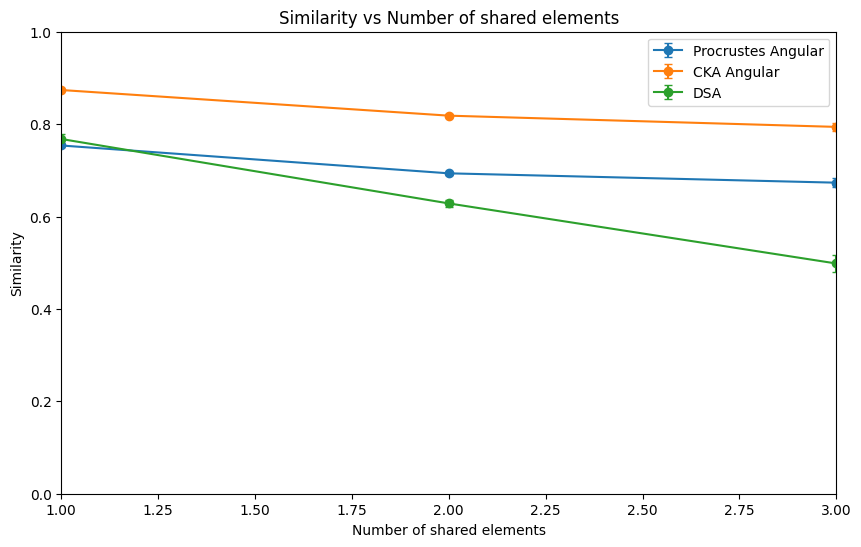

In [ ]:
import matplotlib.pyplot as plt

# Plot dissimilarity as a function of the number of shared elements for pa, cka, and dsa and fix the y-axis between 0 and 1
plt.figure(figsize=(10, 6))

# Plot for Procrustes Angular
plt.errorbar(
    x=dissimilarity_pa["number_of_shared_elements"],
    y=dissimilarity_pa["similarity"],
    yerr=dissimilarity_pa["standard_error"],  # Standard error
    label="Procrustes Angular",
    fmt="-o",  # Line style and marker
    capsize=3,  # Caps on error bars
)

# Plot for CKA Angular
plt.errorbar(
    x=dissimilarity_cka["number_of_shared_elements"],
    y=dissimilarity_cka["similarity"],
    yerr=dissimilarity_cka["standard_error"],  # Standard error
    label="CKA Angular",
    fmt="-o",  # Line style and marker
    capsize=3,  # Caps on error bars
)

# Plot for DSA
plt.errorbar(
    x=dissimilarity_dsa["number_of_shared_elements"],
    y=dissimilarity_dsa["similarity"],
    yerr=dissimilarity_dsa["standard_error"],  # Standard error
    label="DSA",
    fmt="-o",  # Line style and marker
    capsize=3,  # Caps on error bars
)

# Customize the plot
plt.xlabel("Number of shared elements")
plt.ylabel("Similarity")
plt.title("Similarity vs Number of shared elements")
plt.xlim(1, 3)
plt.ylim(0, 1)
plt.legend()

# Show the plot
plt.show()

### Ordered

In [ ]:
def same_order(comp_motif_1, comp_motif_2) -> bool:
    return len(
        [i for i in range(len(comp_motif_1)) if comp_motif_1[i] == comp_motif_2[i]]
    )

In [ ]:
grouped_by_shared_elements_ordered = {i: [] for i in range(0,4)}
for comp_motif_1 in model_names:
    for comp_motif_2 in model_names:
        grouped_by_shared_elements_ordered[same_order(comp_motif_1, comp_motif_2)].extend(
            [(comp_motif_1, comp_motif_2)]
        )

In [ ]:
dissimilarities_pa_grouped_by_shared_elements_ordered = {i: [] for i in range(0, 4)}
for key in grouped_by_shared_elements_ordered:
    for tuple1, tuple2 in grouped_by_shared_elements_ordered[key]:
        similarity_pa = dissimilarities_pa[
            model_names.index(tuple1), model_names.index(tuple2)
        ]
        dissimilarities_pa_grouped_by_shared_elements_ordered[key].append(
            similarity_pa
        )

dissimilarities_cka_grouped_by_shared_elements_ordered = {i: [] for i in range(0, 4)}
for key in grouped_by_shared_elements_ordered:
    for tuple1, tuple2 in grouped_by_shared_elements_ordered[key]:
        similarity_cka = dissimilarities_cka[
            model_names.index(tuple1), model_names.index(tuple2)
        ]
        dissimilarities_cka_grouped_by_shared_elements_ordered[key].append(
            similarity_cka
        )
dissimilarities_dsa_grouped_by_shared_elements_ordered = {i: [] for i in range(0, 4)}
for key in grouped_by_shared_elements_ordered:
    for tuple1, tuple2 in grouped_by_shared_elements_ordered[key]:
        similarity_dsa = dissimilarities_dsa[
            model_names.index(tuple1), model_names.index(tuple2)
        ]
        dissimilarities_dsa_grouped_by_shared_elements_ordered[key].append(
            similarity_dsa
        )

In [ ]:
mean_dissimilarities_pa_ordered = {
    key: np.mean(value)
    for key, value in dissimilarities_pa_grouped_by_shared_elements_ordered.items()
}
standard_errors_dissimilarities_pa_ordered = {
    key: np.std(value) / np.sqrt(len(value))
    for key, value in dissimilarities_pa_grouped_by_shared_elements_ordered.items()
}
mean_dissimilarities_cka_ordered = {
    key: np.mean(value)
    for key, value in dissimilarities_cka_grouped_by_shared_elements_ordered.items()
}
standard_errors_dissimilarities_cka_ordered = {
    key: np.std(value) / np.sqrt(len(value))
    for key, value in dissimilarities_cka_grouped_by_shared_elements_ordered.items()
}
mean_dissimilarities_dsa_ordered = {
    key: np.mean(value)
    for key, value in dissimilarities_dsa_grouped_by_shared_elements_ordered.items()
}
standard_errors_dissimilarities_dsa_ordered = {
    key: np.std(value) / np.sqrt(len(value))
    for key, value in dissimilarities_dsa_grouped_by_shared_elements_ordered.items()
}

In [ ]:
dissimilarity_pa = pd.DataFrame(
    {
        "number_of_shared_elements": list(mean_dissimilarities_pa_ordered.keys()),
        "similarity": list(mean_dissimilarities_pa_ordered.values()),
        "standard_error": list(standard_errors_dissimilarities_pa_ordered.values()),
    }
)
dissimilarity_cka = pd.DataFrame(
    {
        "number_of_shared_elements": list(mean_dissimilarities_cka_ordered.keys()),
        "similarity": list(mean_dissimilarities_cka_ordered.values()),
        "standard_error": list(standard_errors_dissimilarities_cka_ordered.values()),
    }
)
dissimilarity_dsa = pd.DataFrame(
    {
        "number_of_shared_elements": list(mean_dissimilarities_dsa_ordered.keys()),
        "similarity": list(mean_dissimilarities_dsa_ordered.values()),
        "standard_error": list(standard_errors_dissimilarities_dsa_ordered.values()),
    }
)

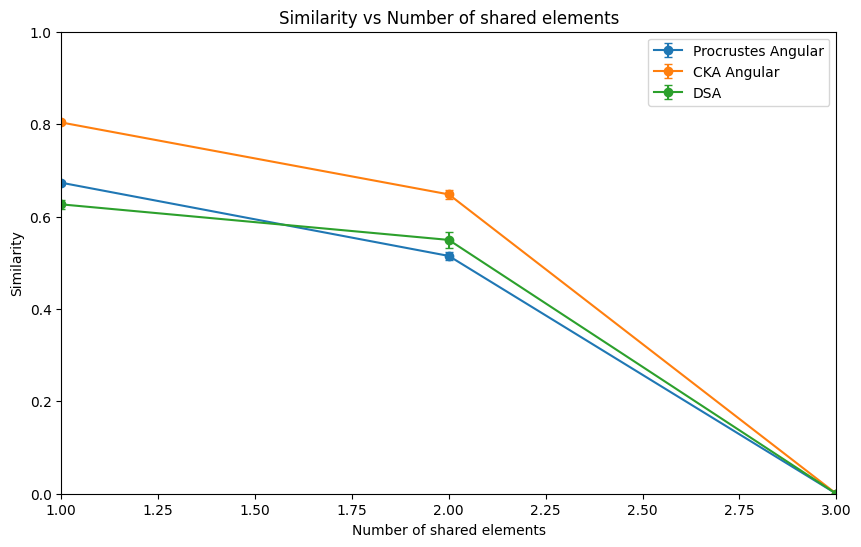

In [ ]:
import matplotlib.pyplot as plt

# Plot dissimilarity as a function of the number of shared elements for pa, cka, and dsa and fix the y-axis between 0 and 1
plt.figure(figsize=(10, 6))

# Plot for Procrustes Angular
plt.errorbar(
    x=dissimilarity_pa["number_of_shared_elements"],
    y=dissimilarity_pa["similarity"],
    yerr=dissimilarity_pa["standard_error"],  # Standard error
    label="Procrustes Angular",
    fmt="-o",  # Line style and marker
    capsize=3,  # Caps on error bars
)

# Plot for CKA Angular
plt.errorbar(
    x=dissimilarity_cka["number_of_shared_elements"],
    y=dissimilarity_cka["similarity"],
    yerr=dissimilarity_cka["standard_error"],  # Standard error
    label="CKA Angular",
    fmt="-o",  # Line style and marker
    capsize=3,  # Caps on error bars
)

# Plot for DSA
plt.errorbar(
    x=dissimilarity_dsa["number_of_shared_elements"],
    y=dissimilarity_dsa["similarity"],
    yerr=dissimilarity_dsa["standard_error"],  # Standard error
    label="DSA",
    fmt="-o",  # Line style and marker
    capsize=3,  # Caps on error bars
)

# Customize the plot
plt.xlabel("Number of shared elements")
plt.ylabel("Similarity")
plt.title("Similarity vs Number of shared elements")
plt.xlim(1, 3)
plt.ylim(0, 1)
plt.legend()

# Show the plot
plt.show()

## References

[1]: Mitchell Ostrow, Adam Eisen, Leo Kozachkov, Ila Fiete, "Beyond Geometry: Comparing the Temporal Structure of Computation in Neural Circuits with Dynamical Similarity Analysis", 	arXiv:2306.10168
 